In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import jit
import scipy.optimize as spopt
from scipy.optimize import curve_fit

In [2]:
# set the events with the corresponding rates
@numba.jit(nopython=True)

def propensities(state,c,activation,ligand,methylation,N,
                delta_f=-2,E0=3,Ki=18,Ka=2900,taul=0.001,kR=0.1,kB=0.2,kAct=50):
    # set arrays to store results
    rates = np.zeros(4)
    events = np.zeros((4,3))

    # calculate free-energy difference
    f = E0 + state[1]*np.log(Ka/Ki) + delta_f*state[2]

    # set rate constants for (de)activation
    kDeact = kAct*np.exp(f)
    
    # set ligand binding rate constant
    kplus = 1/(taul*(c + Ki))

    # check methylation states
    mMax = 4*N
    meth_ceiling = state[2] < mMax
    meth_floor = state[2] > 0

    # for inactive cluster
    if state[0] == 0:
        # methylation; only possible if a site is available
        rates[0] = kR*meth_ceiling*methylation
        events[0] = [0,0,1]

        # activity switching
        rates[1] = kAct*activation
        events[1] = [1,0,0]
        
        # ligand binding
        rates[2] = kplus*c*(N-state[1])*ligand
        events[2] = [0,1,0]
        
        # ligand unbinding
        rates[3] = kplus*Ki*state[1]*ligand
        events[3] = [0,-1,0]

    # for active cluster
    else:
        # demethylation; only possible if a site is occupied
        rates[0] = kB*meth_floor*methylation
        events[0] = [0,0,-1]

        # deactivation
        rates[1] = kDeact*activation
        events[1] = [-1,0,0]
        
        # ligand binding
        rates[2] = kplus*c*(N-state[1])*ligand
        events[2] = [0,1,0]
        
        # ligand unbinding
        rates[3] = kplus*Ka*state[1]*ligand
        events[3] = [0,-1,0]
        
    return rates, events

@numba.jit(nopython=True)

def gillespie_full(a0,l0,m0,tf,n_steps,n_sims,step_change,cnew,
                    Nr=6,mMax=24,activation=True,ligand=True,methylation=True,cbase=100):
    # set up arrays to hold the results
    t_grid = np.linspace(0,tf,n_steps+1)
    all_states = np.zeros((n_sims,n_steps+1,3))
    
    # set initial state
    all_states[:,0,0] = a0
    all_states[:,0,1] = l0
    all_states[:,0,2] = m0
    
    ############# actual algorithm #############
    
    for i in range(n_sims):
        # initialise each realisation
        state = np.array([a0,l0,m0])
        dt = 0
        time = 0
        
        # loop over all time steps
        for j in range(n_steps):
            # change concentration after step_change time steps
            if j >= step_change:
                c = cnew
            else:
                c = cbase
                
            # ensure initialisation; not necessary after initial round
            if time == 0:
                # set state to extract rates and propensities
                rates, events = propensities(state,c,activation,ligand,methylation,Nr)

                # determine which event occurs
                p = np.random.uniform(0,1)*np.sum(rates)
                mask = p < np.cumsum(rates)
                event_idx = np.where(mask == True)[0][0]

                # this samples the time until the next event
                u = np.random.uniform(0,1)
                dt = -np.log(u)/np.sum(rates)
                time += dt
                
            # keep updating until we reach the end of the interval
            while time < t_grid[j]:                
                # extract rates and propensities for next round
                state = state + events[event_idx]
                rates, events = propensities(state,c,activation,ligand,methylation,Nr)

                # determine which event occurs
                p = np.random.uniform(0,1)*np.sum(rates)
                mask = p < np.cumsum(rates)
                event_idx = np.where(mask == True)[0][0]

                # this samples the time until the next event
                u = np.random.uniform(0,1)
                dt = -np.log(u)/np.sum(rates)
                time += dt
                
            # save the last state before passing the boundary
            all_states[i,j+1,:] = state
            
    ############ averaging ############
    
    av_states = np.zeros((n_steps+1,3))
    av_states[0,0] = a0
    av_states[0,1] = l0
    av_states[0,2] = m0
    
    # averaging in the awkward numba way
    for j in range(n_steps):
        for k in range(3):
            av_states[j+1,k] = np.mean(all_states[:,j+1,k])
            
    # normalise
    av_states[:,1] = av_states[:,1]/Nr
    av_states[:,2] = av_states[:,2]/(4*Nr)
            
    return av_states, t_grid

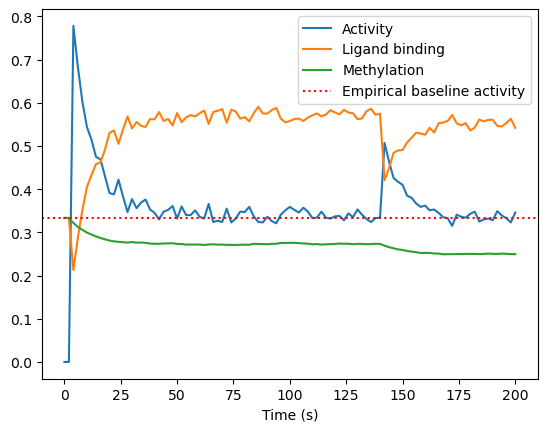

In [3]:
a0 = 0.
l0 = 2.
m0 = 8.
tf = 200
n_steps = 100
n_sims = 10**3
step_change = 70
cnew = 80

results, time = gillespie_full(a0,l0,m0,tf,n_steps,n_sims,step_change,cnew)

plt.plot(time,results[:,0],label='Activity')
plt.plot(time,results[:,1],label='Ligand binding')
plt.plot(time,results[:,2],label='Methylation')
plt.axhline(y=1/3,xmin=0,xmax=1,linestyle=':',color='r',label='Empirical baseline activity')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

**Problem**: this looks pretty much like what we are looking for, but there are three issues to take into account compared to the case without ligand binding:

- the simulation is much slower with ligand binding
- there does not appear to be a clear time scale separation between ligand and activity dynamics

## Fitting to Extract Response and Adaptation Timescale

This part uses a model proposed by Mattingly et al. (2021) for the shape of the response curve as

$$ K(t) = G \exp\{-t/\tau_2\}(1 - \exp\{-t/\tau_1\})H(t), $$

where $K(t)$ is the activity, $G$ is the gain or amplitude, $\tau_1$ is the rise time, $\tau_2$ is the adaptation time and $H(t)$ is the Heaviside step function. Note that we have subtracted the baseline activity and set $t=0$ when the concentration is increased. Furthermore, Mattingly et al. only probed responses for a 10% increase or decrease in concentration, starting from a background of 100 $\mu$M.Additionally, this model is fitted to a rescaled version of the activity. Concretely, $K(t)$ is fitted to $a(t)/\log(c_0/c_f)$, where $c_f = 90 \, \mu$M is the final concentration and $c_0 = 100\,\mu$M is the baseline concentration. 

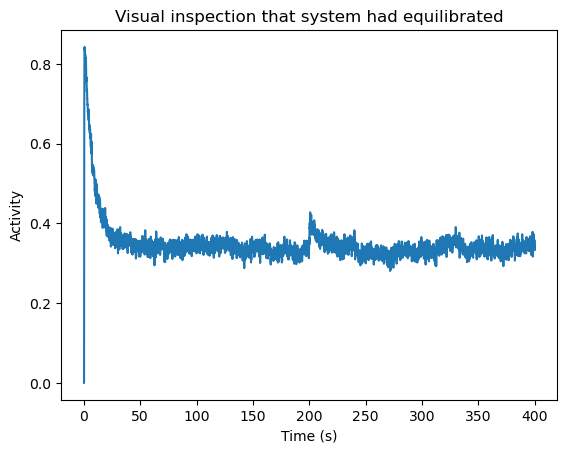

/tmp/ipykernel_6109/3269641167.py:29: RuntimeWarning: overflow encountered in exp
  return G*np.exp(-t/tau2)*(1 - np.exp(-t/tau1))


Parameters of best fit: [G, tau1, tau2] = [0.63974474 0.48994361 2.60872326]
Covariances: [[ 0.1421434   0.19297947 -0.43391549]
 [ 0.19297947  0.34278314 -0.55008413]
 [-0.43391549 -0.55008413  1.59066468]]
Standard deviations: [0.3770190994420734, 0.585476851874283, 1.2612155559792164]


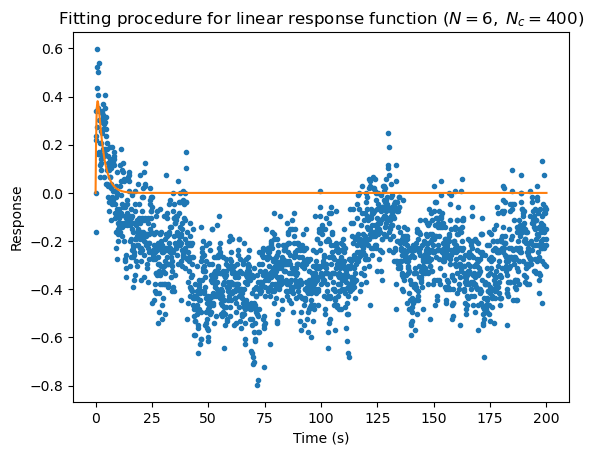

In [4]:
# obtain nice data
a0 = 0.
l0 = 2.
m0 = 8.
tf = 400
n_steps = 4000
n_sims = 10**3
step_change = 2000
cnew = 90

results, time = gillespie_full(a0,l0,m0,tf,n_steps,n_sims,step_change,cnew)

# find response and shift time accordingly
activity = results[:,0]
shifted_activity = activity[step_change-1:] - activity[step_change-1]
response = shifted_activity/np.log(100/cnew)

shifted_time = time[step_change-1:] - time[step_change-1]

# visual inspection that the system had equilibrated
plt.plot(time,activity)
plt.xlabel('Time (s)')
plt.ylabel('Activity')
plt.title('Visual inspection that system had equilibrated')
plt.show()

# define model function
def mattingly_fit(t,G,tau1,tau2):
    return G*np.exp(-t/tau2)*(1 - np.exp(-t/tau1))

# perform fitting
popt, pcov = curve_fit(mattingly_fit,shifted_time,response)
print('Parameters of best fit: [G, tau1, tau2] =',popt)
print('Covariances:', pcov)
print('Standard deviations:', [np.sqrt(pcov[i,i]) for i in range(3)])

# show results
plt.plot(shifted_time,response,'.',label='Simulation')
plt.plot(shifted_time, mattingly_fit(shifted_time, *popt),label='Fit')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.title(r'Fitting procedure for linear response function ($N=6, \; N_c = 400$)')
plt.show()

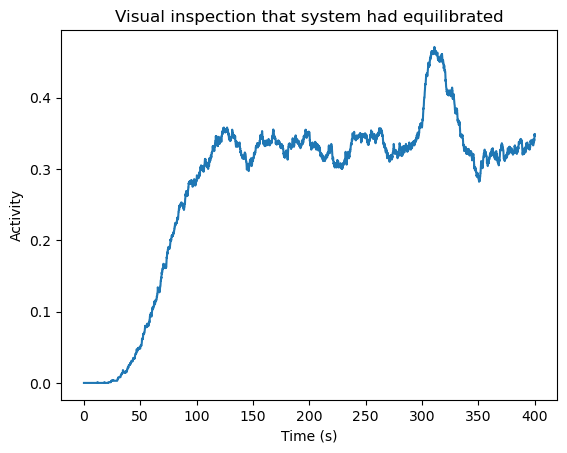

Parameters of best fit: [G, tau1, tau2] = [4.06455385e+03 1.10061739e+04 7.51359518e+00]
Covariances: [[ 3.46562622e+14  9.38509188e+14 -2.70616902e+08]
 [ 9.38509188e+14  2.54153056e+15 -7.32844207e+08]
 [-2.70616902e+08 -7.32844207e+08  2.11370520e+02]]
Standard deviations: [18616192.47665236, 50413595.03050807, 14.538587280300193]


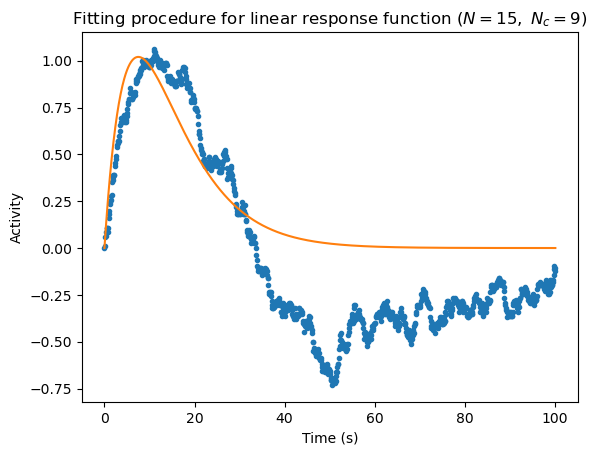

In [5]:
# for different cluster parameters
# obtain nice data
a0 = 0.
l0 = 2.
m0 = 8.
tf = 400
n_steps = 4000
n_sims = 10**3
step_change = 3000
cnew = 90

results, time = gillespie_full(a0,l0,m0,tf,n_steps,n_sims,step_change,cnew,Nr=15)

# find response and shift time accordingly
activity = results[:,0]
shifted_activity = activity[step_change-1:] - activity[step_change-1]
response = shifted_activity/np.log(100/cnew)

shifted_time = time[step_change-1:] - time[step_change-1]

# visual inspection that the system had equilibrated
plt.plot(time,activity)
plt.xlabel('Time (s)')
plt.ylabel('Activity')
plt.title('Visual inspection that system had equilibrated')
plt.show()

# perform fitting
popt, pcov = curve_fit(mattingly_fit,shifted_time,response)
print('Parameters of best fit: [G, tau1, tau2] =',popt)
print('Covariances:', pcov)
print('Standard deviations:', [np.sqrt(pcov[i,i]) for i in range(3)])

# show results
plt.plot(shifted_time,response,'.',label='Simulation')
plt.plot(shifted_time, mattingly_fit(shifted_time, *popt),label='Fit')
plt.xlabel('Time (s)')
plt.ylabel('Activity')
plt.title(r'Fitting procedure for linear response function ($N=15, \; N_c = 9$)')
plt.show()

**Problem**: the adaptation does not appear to be perfect, so the current method sometimes causes most values to be negative. This messes up the fit. How should I adapt the method to prevent this from happening? I have two ideas:

- take the step on step_change as the baseline instead of the step right before
- add a constant to the fitting function and fit without shifting the response down

## Noise kernel

Here we estimate the noise kernel in order to compare our results to Mattingly et al.'s work. The aim is to find the autocorrelator, which we do as follows. Firstly, we simulate a trajectory $a(t)$ on the cell level, meaning that it is averaged over $N_c = 400$ clusters. Since we are interested in the steady-state noise, the background concentration is kept constant at $c = 100\,\mu$M and the transient until reaching equilibrium is cut off. We then subtract the baseline activity to obtain a down-shifted activity measure, $x(t) \equiv a(t) - a_0$ and from this compute the autocorrelator $x(0)x(t)$, where we set $t=0$ at the cut-off of the transient. We repeat this several times and take an ensemble average to produce precise results for $N(t)$.

Measurements indicate that $x(t)$ is well approximated by an Ornstein-Uhlenbeck process, such that the noise kernel is of the form

$$ N(t) = \sigma_n^2 \exp\{-t/\tau_n\}, $$

where $\sigma_n$ sets the amplitude and $\tau_n$ the time scale of the fluctuations in $x(t)$. From their measurements, Mattingly et al. find that $\sigma_n = 0.092 \pm 0.002$ and $\tau_n = 11.75 \pm 0.04$ s, so the aim of this section is to check whether our simulations agree with these values.

In [6]:
@numba.jit(nopython=True)

def autocorrelator(n_steps,N=6,Nc=400,a0=0.,l0=2.,m0=8.,tf=400,n_sims=10**1,step_change=100,cnew=100):
    # set cut-off to remove transient
    cutoff = int(np.floor(0.7*n_steps))
        
    # array to save results
    all_corr = np.zeros((n_sims,n_steps-cutoff),dtype='float32')
    
    # repeat for many simulations
    for i in range(n_sims):
        # obtain activity and shifted time
        results, time = gillespie_full(a0,l0,m0,tf,n_steps,Nc,step_change,cnew,Nr=N)
        activity = results[cutoff+1:,0]
        time_shifted = time[cutoff+1:] - time[cutoff+1]
        
        # normalise to baseline
        activity_x = activity - results[cutoff,0]
        
        # compute autocorrelations
        for j,act in enumerate(activity_x):
            all_corr[i,j] = activity_x[0]*act
        
    # take ensemble average
    av_corr = np.zeros_like(time_shifted)
    
    for j in range(time_shifted.size):
        av_corr[j] = np.mean(all_corr[:,j])
        
    return av_corr, time_shifted

In [ ]:
# obtain autocorrelator data
n_steps = 400
corr_data, time_shifted = autocorrelator(n_steps)

# define model function
def noise_fit(t,sigma,taun):
    return sigma**2*np.exp(-np.abs(t)/taun)

# perform fitting
popt, pcov = curve_fit(noise_fit,time_shifted[1:],corr_data[1:])
print('Parameters of best fit: [sigma, tau_n] =',popt)
print('Covariances:', pcov)
print('Standard deviations:', [np.sqrt(pcov[i,i]) for i in range(2)])

# show results
plt.plot(time_shifted[1:],corr_data[1:],'.',label='Simulation')
plt.plot(time_shifted[1:], noise_fit(time_shifted[1:], *popt),label='Fit')
plt.xlabel('Time (s)')
plt.ylabel('Autocorrelator')
plt.title(r'Fitting procedure for autocorrelator ($N=6, \; N_c = 400$)')
plt.show()

### Interpretation

From our fitting procedure, we consistently find values of $\sigma_n$ that are roughly a factor of 10 below Mattingly et al.'s estimate. This agrees with Manuel's findings. Evidently, the dynamic MWC model does not reproduce the data by Mattingly et al. well given the parameters frequently used in the literature. Therefore, we check whether the agreement between simulations and experiment is better if we change the parameter values as suggested by Manuel, so we take $N=15$ and $N_c = 9$ instead of $N=6$ and $N_c=400$. 

In [ ]:
# repeat for different cluster parameters
# obtain autocorrelator data
n_steps = 400
corr_data, time_shifted = autocorrelator(n_steps,N=15,Nc=9)

# perform fitting
popt, pcov = curve_fit(noise_fit,time_shifted[1:],corr_data[1:])
print('Parameters of best fit: [sigma, tau_n] =',popt)
print('Covariances:', pcov)
print('Standard deviations:', [np.sqrt(pcov[i,i]) for i in range(2)])

# show results
plt.plot(time_shifted[1:],corr_data[1:],'.',label='Simulation')
plt.plot(time_shifted[1:], noise_fit(time_shifted[1:], *popt),label='Fit')
plt.xlabel('Time (s)')
plt.ylabel('Autocorrelator')
plt.title(r'Fitting procedure for autocorrelator ($N=15, \; N_c = 9$)')
plt.show()

## Dose-response curve

In this section, we use the simulation to extract the dose-response curve. The procedure is as follows. We turn methylation off to prevent adaptation. After equilibration, the cluster receives a step increase in concentration, upon which the activity settles to a new equilibrium. We measure the amplitude of the response as the difference between the activity just before the change in concentration and the new equilibrium activity, which we take from the last point of the simulation. Repeating this procedure for various values of the final concentration allows us to extract a dose-response curve. 

The aim here is not to replicate any measured dose-response curve. Instead, the aim is to reproduce some qualitative characteristics of a typical dose-response curve extracted from an MWC model, such as its sigmoidal shape. This would provide evidence that our model agrees with the non-dynamical MWC model.

In [ ]:
# define a function that finds the response for an array of concentration
@numba.jit(nopython=True)

def response_finder(cnew_arr,a0=0.,l0=2.,m0=8.,tf=100,n_steps=100,n_sims=10**2):
    # set when the concentration is changed
    step_change = int(np.floor(0.4*n_steps))
    
    # array to store results
    all_responses = np.zeros(cnew_arr.size)
    
    # loop for various new concentrations
    for i, cnew in enumerate(cnew_arr):
        # obtain activity and time
        results,_ = gillespie_full(a0,l0,m0,tf,n_steps,n_sims,step_change,cnew,methylation=False)
        activity = results[:,0]
        
        # set baseline and extract new equilibrium
        baseline = activity[step_change-1]
        new_act = activity[-1]
        
        # save response
        all_responses[i] = new_act - baseline
    
    return all_responses

In [ ]:
# find responses
cnew_arr = np.logspace(0.5,3.5,100)
responses = response_finder(cnew_arr)

# show results
plt.semilogx(cnew_arr,responses,'.')
plt.xlabel(r'Final concentration ($\mu$M)')
plt.ylabel('Change in equilibrium activity')
plt.title(r'Dose-response curve (base: $c=100\, \mu$M)')
plt.show()

This result looks like what we would expect from a cooperative cluster!